<a href="https://colab.research.google.com/github/regitanina/ANALISIS-SENTIMEN-LSTM-DAN-GLOVE/blob/main/FASE_1_(IndoBERT_Pelabelan_Data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/IndoNLP/indonlu.git
%cd indonlu

Cloning into 'indonlu'...
remote: Enumerating objects: 509, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 509 (delta 119), reused 139 (delta 110), pack-reused 316 (from 1)
Receiving objects: 100% (509/509), 9.46 MiB | 12.32 MiB/s, done.
Resolving deltas: 100% (239/239), done.
/content/indonlu


In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 22.2 MB/s eta 0:00:00
  

In [ ]:
!pip install nltk==3.6.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.3 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.4.5
    Uninstalling nltk-3.4.5:
      Successfully uninstalled nltk-3.4.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
textblob 0.19.0 requires nltk>=3.9, but you have nltk 3.6.7 which is incompatible.


In [ ]:
!ls

CODE_OF_CONDUCT.md   examples  predict.py    requirements.txt	  tutorial
CONTRIBUTING.md      LICENSE   predict.sh    run_all_tasks.sh	  utils
dataset		     main.py   README.id.md  run_single_task.sh
data_utils_notebook  modules   README.md     submission_examples


#Fine Tuning -  Dataset Publik

##Import Library

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

##Load Tokenizer dan Config IndoBERT

In [ ]:
#Load Tokenizer dan Config IndoBERT
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [ ]:
#Definisikan DocumentSentimentDataset
class DocumentSentimentDataset(Dataset):
    LABEL2INDEX = {'negative': 0, 'neutral': 1, 'positive': 2}
    INDEX2LABEL = {0: 'negative', 1: 'neutral', 2: 'positive'}
    NUM_LABELS = 3

    def __init__(self, file_path, tokenizer, lowercase=True):
        self.tokenizer = tokenizer
        self.lowercase = lowercase

        df = pd.read_csv(file_path, sep='\t')
        if lowercase:
            df['text'] = df['text'].str.lower()
        self.texts = df['text'].tolist()
        self.labels = df['sentiment'].map(self.LABEL2INDEX).tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return text, label


In [ ]:
#Definisikan DocumentSentimentDataLoader
class DocumentSentimentDataLoader(DataLoader):
    def __init__(self, dataset, max_seq_len=512, batch_size=32, num_workers=4, shuffle=False):
        self.tokenizer = dataset.tokenizer
        self.max_seq_len = max_seq_len

        def collate_fn(batch):
            texts, labels = zip(*batch)
            inputs = self.tokenizer(list(texts), padding=True, truncation=True, max_length=max_seq_len, return_tensors="pt")
            labels = torch.tensor(labels)
            return inputs['input_ids'], inputs['attention_mask'], labels

        super().__init__(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            collate_fn=collate_fn
        )


##Load Dataset Publik

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load Semua Dataset
# Dictionary path dataset
dataset_paths = {
    "dataset_a": {
        "train": "/content/drive/MyDrive/Colab Notebooks/Skripsi/Dataset Publik/dataset_a/train.tsv",
        "valid": "/content/drive/MyDrive/Colab Notebooks/Skripsi/Dataset Publik/dataset_a/valid.tsv",
        "test": "/content/drive/MyDrive/Colab Notebooks/Skripsi/Dataset Publik/dataset_a/test.tsv",
    },
    "dataset_b": {
        "train": "/content/drive/MyDrive/Colab Notebooks/Skripsi/Dataset Publik/dataset_b/train.tsv",
        "valid": "/content/drive/MyDrive/Colab Notebooks/Skripsi/Dataset Publik/dataset_b/valid.tsv",
        "test": "/content/drive/MyDrive/Colab Notebooks/Skripsi/Dataset Publik/dataset_b/test.tsv",
    },
    "dataset_c": {
        "train": "/content/drive/MyDrive/Colab Notebooks/Skripsi/Dataset Publik/dataset_c/train.tsv",
        "valid": "/content/drive/MyDrive/Colab Notebooks/Skripsi/Dataset Publik/dataset_c/valid.tsv",
        "test": "/content/drive/MyDrive/Colab Notebooks/Skripsi/Dataset Publik/dataset_c/test.tsv",
    },
}


In [ ]:
# Load semua dataset pakai looping
loaded_datasets = {}
for dataset_name, paths in dataset_paths.items():
    loaded_datasets[dataset_name] = {
        'train': DocumentSentimentDataset(paths['train'], tokenizer, lowercase=True),
        'valid': DocumentSentimentDataset(paths['valid'], tokenizer, lowercase=True),
        'test': DocumentSentimentDataset(paths['test'], tokenizer, lowercase=True)
    }

In [ ]:
# Load semua DataLoader
loaded_dataloaders = {}
for dataset_name, datasets in loaded_datasets.items():
    loaded_dataloaders[dataset_name] = {
        'train': DocumentSentimentDataLoader(dataset=datasets['train'], max_seq_len=512, batch_size=32, num_workers=16, shuffle=True),
        'valid': DocumentSentimentDataLoader(dataset=datasets['valid'], max_seq_len=512, batch_size=32, num_workers=16, shuffle=False),
        'test': DocumentSentimentDataLoader(dataset=datasets['test'], max_seq_len=512, batch_size=32, num_workers=16, shuffle=False),
    }

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


##Load Model IndoBERT

In [ ]:
#Load Model IndoBERT
# Update config
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Load model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

##Training dan Evaluasi Model


=== Mulai Training untuk dataset_a ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

[dataset_a] Epoch 1 - Training: 100%|██████████| 350/350 [02:47<00:00,  2.09it/s]

[dataset_a] Epoch 1 - Train Loss: 0.2701
              precision    recall  f1-score   support

    negative     0.8730    0.8651    0.8690      3559
     neutral     0.8536    0.7746    0.8122      1167
    positive     0.9247    0.9447    0.9346      6472

    accuracy                         0.9017     11198
   macro avg     0.8838    0.8615    0.8719     11198
weighted avg     0.9008    0.9017    0.9010     11198




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_a] Epoch 1 - Validation Loss: 0.2034
              precision    recall  f1-score   support

    negative     0.8900    0.9442    0.9163       394
     neutral     0.9174    0.7634    0.8333       131
    positive     0.9577    0.9551    0.9564       735

    accuracy                         0.9317      1260
   macro avg     0.9217    0.8875    0.9020      1260
weighted avg     0.9323    0.9317    0.9311      1260



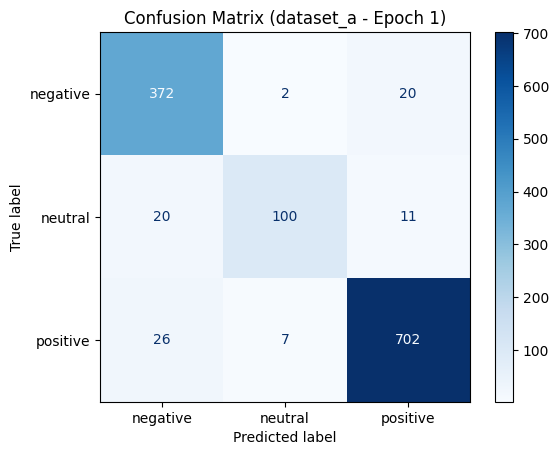

[dataset_a] Epoch 2 - Training:   0%|          | 0/350 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[dataset_a] Epoch 2 - Training: 100%|██████████| 350/350 [02:50<00:00,  2.05it/s]

[dataset_a] Epoch 2 - Train Loss: 0.1319
              precision    recall  f1-score   support

    negative     0.9352    0.9365    0.9358      3559
     neutral     0.9539    0.9220    0.9377      1167
    positive     0.9633    0.9683    0.9658      6472

    accuracy                         0.9534     11198
   macro avg     0.9508    0.9423    0.9464     11198
weighted avg     0.9534    0.9534    0.9533     11198




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_a] Epoch 2 - Validation Loss: 0.2128
              precision    recall  f1-score   support

    negative     0.8785    0.9543    0.9148       394
     neutral     0.8909    0.7481    0.8133       131
    positive     0.9640    0.9469    0.9554       735

    accuracy                         0.9286      1260
   macro avg     0.9111    0.8831    0.8945      1260
weighted avg     0.9297    0.9286    0.9279      1260



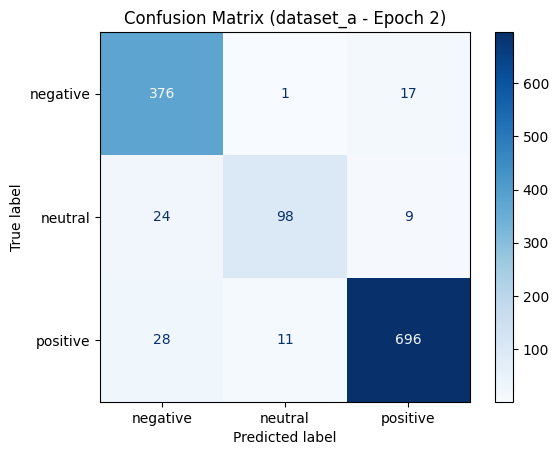

[dataset_a] Epoch 3 - Training:   0%|          | 0/350 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[dataset_a] Epoch 3 - Training: 100%|██████████| 350/350 [02:50<00:00,  2.05it/s]

[dataset_a] Epoch 3 - Train Loss: 0.0726
              precision    recall  f1-score   support

    negative     0.9655    0.9677    0.9666      3559
     neutral     0.9702    0.9494    0.9597      1167
    positive     0.9806    0.9832    0.9819      6472

    accuracy                         0.9747     11198
   macro avg     0.9721    0.9668    0.9694     11198
weighted avg     0.9747    0.9747    0.9747     11198




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_a] Epoch 3 - Validation Loss: 0.2292
              precision    recall  f1-score   support

    negative     0.8765    0.9543    0.9137       394
     neutral     0.8814    0.7939    0.8353       131
    positive     0.9677    0.9388    0.9530       735

    accuracy                         0.9286      1260
   macro avg     0.9085    0.8957    0.9007      1260
weighted avg     0.9302    0.9286    0.9285      1260



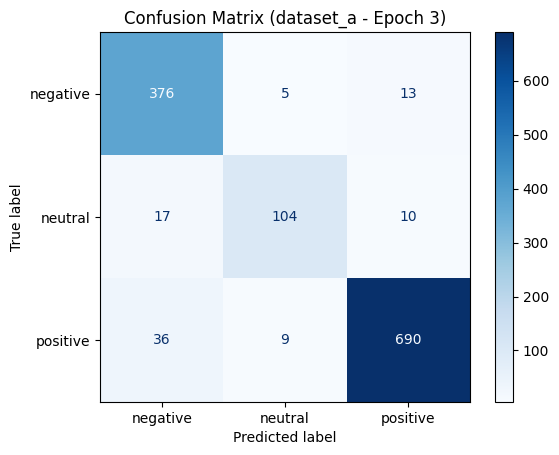

[dataset_a] Epoch 4 - Training:   0%|          | 0/350 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[dataset_a] Epoch 4 - Training: 100%|██████████| 350/350 [02:51<00:00,  2.04it/s]

[dataset_a] Epoch 4 - Train Loss: 0.0419
              precision    recall  f1-score   support

    negative     0.9807    0.9831    0.9819      3559
     neutral     0.9835    0.9717    0.9776      1167
    positive     0.9903    0.9910    0.9907      6472

    accuracy                         0.9865     11198
   macro avg     0.9848    0.9820    0.9834     11198
weighted avg     0.9865    0.9865    0.9865     11198




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_a] Epoch 4 - Validation Loss: 0.2662
              precision    recall  f1-score   support

    negative     0.9052    0.9213    0.9132       394
     neutral     0.9320    0.7328    0.8205       131
    positive     0.9418    0.9687    0.9551       735

    accuracy                         0.9294      1260
   macro avg     0.9264    0.8743    0.8963      1260
weighted avg     0.9294    0.9294    0.9280      1260



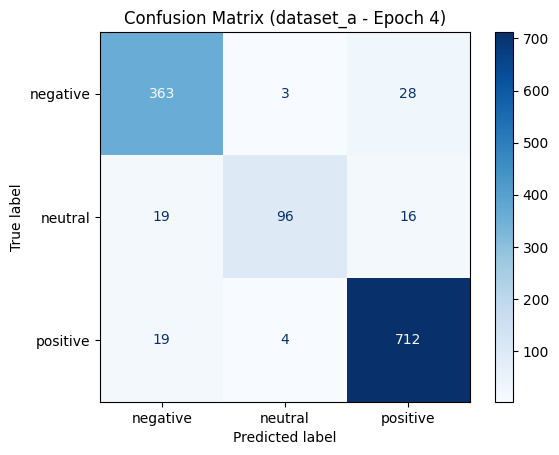

[dataset_a] Epoch 5 - Training:   0%|          | 0/350 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[dataset_a] Epoch 5 - Training: 100%|██████████| 350/350 [02:51<00:00,  2.05it/s]

[dataset_a] Epoch 5 - Train Loss: 0.0364
              precision    recall  f1-score   support

    negative     0.9837    0.9843    0.9840      3559
     neutral     0.9853    0.9786    0.9819      1167
    positive     0.9907    0.9917    0.9912      6472

    accuracy                         0.9879     11198
   macro avg     0.9866    0.9848    0.9857     11198
weighted avg     0.9879    0.9879    0.9879     11198




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_a] Epoch 5 - Validation Loss: 0.2516
              precision    recall  f1-score   support

    negative     0.9012    0.9492    0.9246       394
     neutral     0.8983    0.8092    0.8514       131
    positive     0.9670    0.9565    0.9617       735

    accuracy                         0.9389      1260
   macro avg     0.9222    0.9050    0.9126      1260
weighted avg     0.9393    0.9389    0.9386      1260



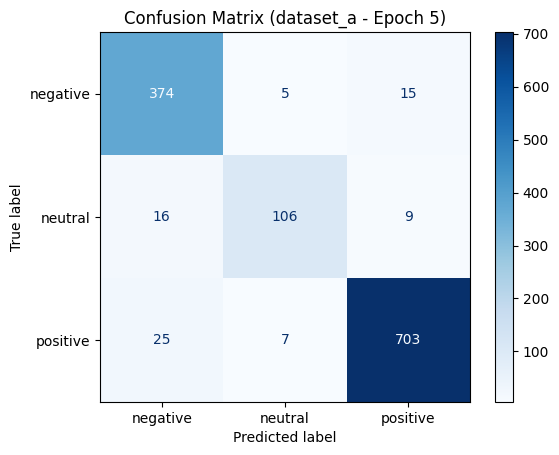

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_a] Test Prediction Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 0, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[dataset_b] Epoch 1 - Training: 100%|██████████| 26/26 [00:07<00:00,  3.48it/s]

[dataset_b] Epoch 1 - Train Loss: 0.5612
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000        23
     neutral     0.8414    0.9529    0.8936       679
    positive     0.2286    0.0741    0.1119       108

    accuracy                         0.8086       810
   macro avg     0.3566    0.3423    0.3352       810
weighted avg     0.7358    0.8086    0.7640       810




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_b] Epoch 1 - Validation Loss: 0.2362
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         1
     neutral     0.9506    1.0000    0.9747        77
    positive     1.0000    0.7500    0.8571        12

    accuracy                         0.9556        90
   macro avg     0.6502    0.5833    0.6106        90
weighted avg     0.9466    0.9556    0.9482        90



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


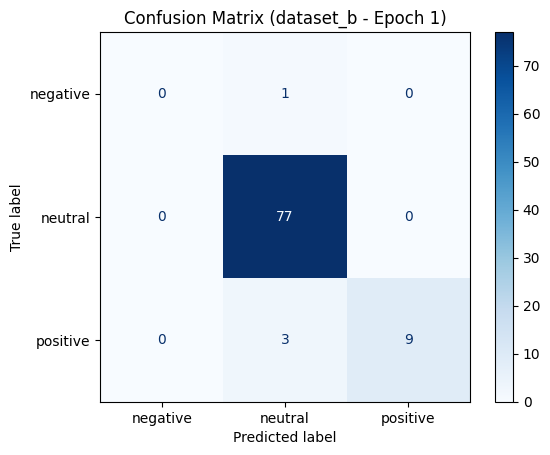

[dataset_b] Epoch 2 - Training:   0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[dataset_b] Epoch 2 - Training: 100%|██████████| 26/26 [00:08<00:00,  3.04it/s]

[dataset_b] Epoch 2 - Train Loss: 0.1439
              precision    recall  f1-score   support

    negative     0.6000    0.1304    0.2143        23
     neutral     0.9740    0.9926    0.9832       679
    positive     0.8850    0.9259    0.9050       108

    accuracy                         0.9593       810
   macro avg     0.8196    0.6830    0.7008       810
weighted avg     0.9515    0.9593    0.9510       810




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_b] Epoch 2 - Validation Loss: 0.0743
              precision    recall  f1-score   support

    negative     1.0000    1.0000    1.0000         1
     neutral     0.9872    1.0000    0.9935        77
    positive     1.0000    0.9167    0.9565        12

    accuracy                         0.9889        90
   macro avg     0.9957    0.9722    0.9834        90
weighted avg     0.9890    0.9889    0.9887        90



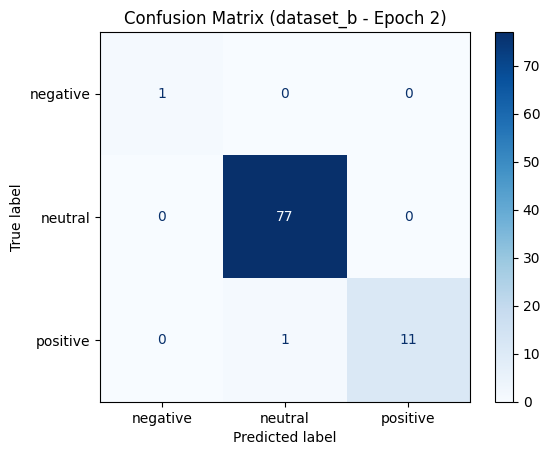

[dataset_b] Epoch 3 - Training:   0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[dataset_b] Epoch 3 - Training: 100%|██████████| 26/26 [00:07<00:00,  3.40it/s]

[dataset_b] Epoch 3 - Train Loss: 0.0687
              precision    recall  f1-score   support

    negative     0.8182    0.7826    0.8000        23
     neutral     0.9970    0.9912    0.9941       679
    positive     0.9292    0.9722    0.9502       108

    accuracy                         0.9827       810
   macro avg     0.9148    0.9153    0.9148       810
weighted avg     0.9829    0.9827    0.9827       810




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_b] Epoch 3 - Validation Loss: 0.0693
              precision    recall  f1-score   support

    negative     1.0000    1.0000    1.0000         1
     neutral     0.9872    1.0000    0.9935        77
    positive     1.0000    0.9167    0.9565        12

    accuracy                         0.9889        90
   macro avg     0.9957    0.9722    0.9834        90
weighted avg     0.9890    0.9889    0.9887        90



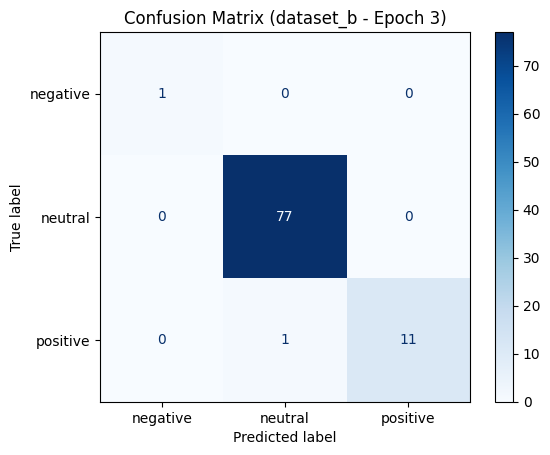

[dataset_b] Epoch 4 - Training:   0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[dataset_b] Epoch 4 - Training: 100%|██████████| 26/26 [00:07<00:00,  3.54it/s]

[dataset_b] Epoch 4 - Train Loss: 0.0634
              precision    recall  f1-score   support

    negative     0.8947    0.7391    0.8095        23
     neutral     0.9970    0.9941    0.9956       679
    positive     0.9211    0.9722    0.9459       108

    accuracy                         0.9840       810
   macro avg     0.9376    0.9018    0.9170       810
weighted avg     0.9840    0.9840    0.9837       810




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_b] Epoch 4 - Validation Loss: 0.0379
              precision    recall  f1-score   support

    negative     0.5000    1.0000    0.6667         1
     neutral     1.0000    1.0000    1.0000        77
    positive     1.0000    0.9167    0.9565        12

    accuracy                         0.9889        90
   macro avg     0.8333    0.9722    0.8744        90
weighted avg     0.9944    0.9889    0.9905        90



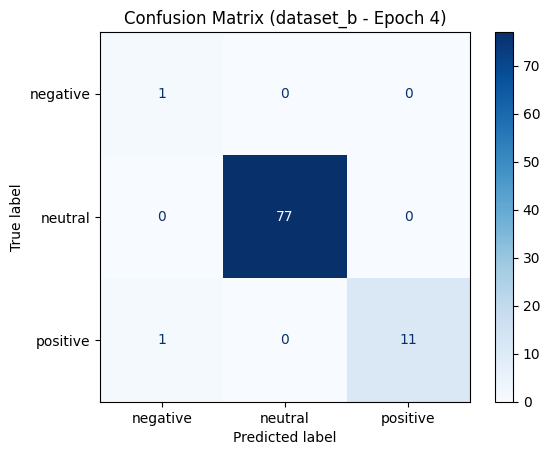

[dataset_b] Epoch 5 - Training:   0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[dataset_b] Epoch 5 - Training: 100%|██████████| 26/26 [00:07<00:00,  3.29it/s]

[dataset_b] Epoch 5 - Train Loss: 0.0470
              precision    recall  f1-score   support

    negative     0.8750    0.9130    0.8936        23
     neutral     0.9985    0.9941    0.9963       679
    positive     0.9545    0.9722    0.9633       108

    accuracy                         0.9889       810
   macro avg     0.9427    0.9598    0.9511       810
weighted avg     0.9891    0.9889    0.9890       810




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_b] Epoch 5 - Validation Loss: 0.0246
              precision    recall  f1-score   support

    negative     1.0000    1.0000    1.0000         1
     neutral     0.9872    1.0000    0.9935        77
    positive     1.0000    0.9167    0.9565        12

    accuracy                         0.9889        90
   macro avg     0.9957    0.9722    0.9834        90
weighted avg     0.9890    0.9889    0.9887        90



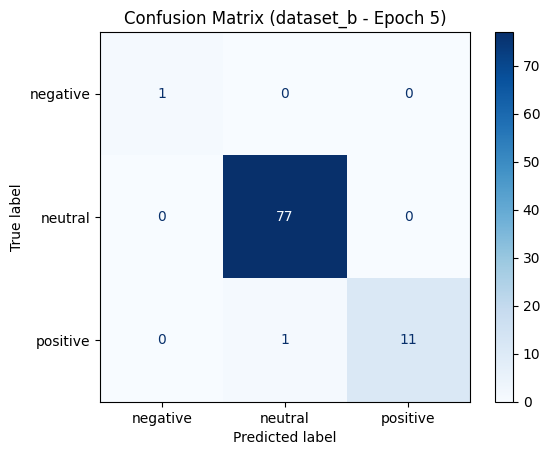

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_b] Test Prediction Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
✅ Model dataset_b disimpan di: /content/drive/MyDrive/Colab Notebooks/Skripsi/Model/saved_model_dataset_b.pt

=== Mulai Training untuk dataset_c ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[dataset_c] Epoch 1 - Training: 100%|██████████| 72/72 [00:34<00:00,  2.06it/s]

[dataset_c] Epoch 1 - Train Loss: 0.3131
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000        30
     neutral     0.9150    0.9743    0.9437      2023
    positive     0.5984    0.3174    0.4148       230

    accuracy                         0.8953      2283
   macro avg     0.5045    0.4306    0.4528      2283
weighted avg     0.8711    0.8953    0.8780      2283




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_c] Epoch 1 - Validation Loss: 0.1692
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         2
     neutral     0.9837    0.9565    0.9699       253
    positive     0.7179    0.9333    0.8116        30

    accuracy                         0.9474       285
   macro avg     0.5672    0.6300    0.5938       285
weighted avg     0.9489    0.9474    0.9465       285



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


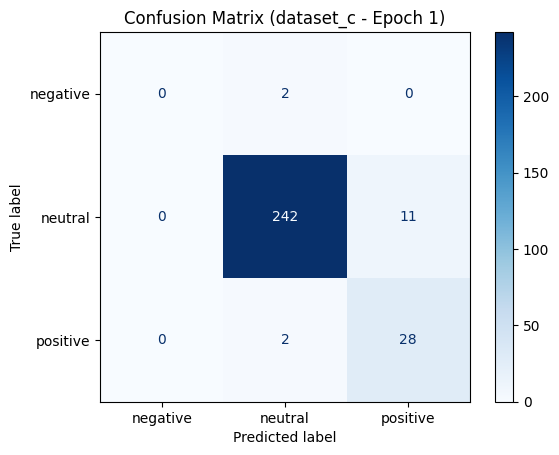

[dataset_c] Epoch 2 - Training:   0%|          | 0/72 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[dataset_c] Epoch 2 - Training: 100%|██████████| 72/72 [00:33<00:00,  2.15it/s]

[dataset_c] Epoch 2 - Train Loss: 0.1628
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000        30
     neutral     0.9668    0.9802    0.9735      2023
    positive     0.8147    0.8217    0.8182       230

    accuracy                         0.9514      2283
   macro avg     0.5938    0.6007    0.5972      2283
weighted avg     0.9388    0.9514    0.9451      2283




/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/ut

[dataset_c] Epoch 2 - Validation Loss: 0.1459
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         2
     neutral     0.9797    0.9526    0.9659       253
    positive     0.6923    0.9000    0.7826        30

    accuracy                         0.9404       285
   macro avg     0.5573    0.6175    0.5828       285
weighted avg     0.9426    0.9404    0.9399       285



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


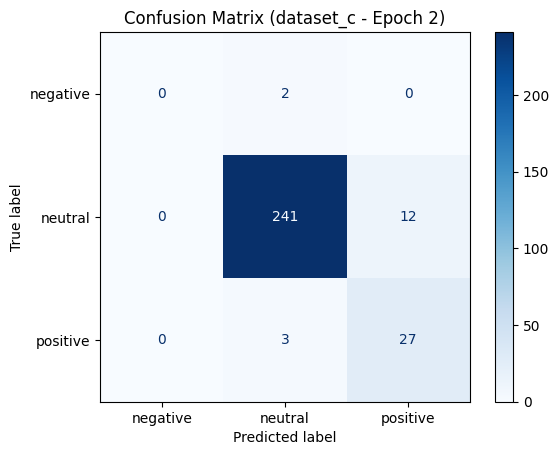

[dataset_c] Epoch 3 - Training:   0%|          | 0/72 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[dataset_c] Epoch 3 - Training: 100%|██████████| 72/72 [00:33<00:00,  2.14it/s]

[dataset_c] Epoch 3 - Train Loss: 0.1113
              precision    recall  f1-score   support

    negative     0.6667    0.2667    0.3810        30
     neutral     0.9765    0.9857    0.9811      2023
    positive     0.8603    0.8565    0.8584       230

    accuracy                         0.9632      2283
   macro avg     0.8345    0.7030    0.7401      2283
weighted avg     0.9607    0.9632    0.9608      2283




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_c] Epoch 3 - Validation Loss: 0.1176
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         2
     neutral     0.9760    0.9644    0.9702       253
    positive     0.7647    0.8667    0.8125        30

    accuracy                         0.9474       285
   macro avg     0.5802    0.6104    0.5942       285
weighted avg     0.9469    0.9474    0.9468       285



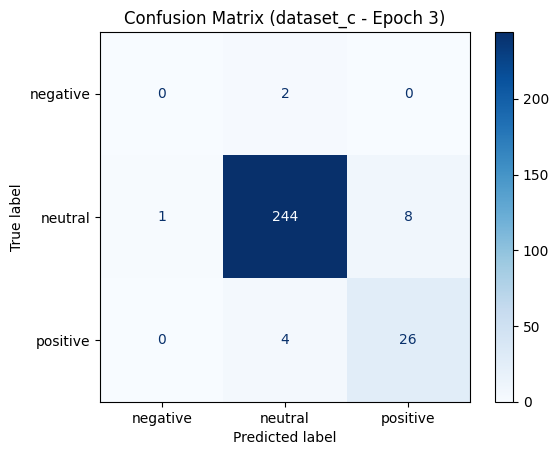

[dataset_c] Epoch 4 - Training:   0%|          | 0/72 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[dataset_c] Epoch 4 - Training: 100%|██████████| 72/72 [00:33<00:00,  2.16it/s]

[dataset_c] Epoch 4 - Train Loss: 0.0504
              precision    recall  f1-score   support

    negative     0.9583    0.7667    0.8519        30
     neutral     0.9901    0.9936    0.9919      2023
    positive     0.9476    0.9435    0.9455       230

    accuracy                         0.9855      2283
   macro avg     0.9654    0.9012    0.9297      2283
weighted avg     0.9854    0.9855    0.9854      2283




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_c] Epoch 4 - Validation Loss: 0.1396
              precision    recall  f1-score   support

    negative     0.5000    0.5000    0.5000         2
     neutral     0.9878    0.9605    0.9739       253
    positive     0.7568    0.9333    0.8358        30

    accuracy                         0.9544       285
   macro avg     0.7482    0.7979    0.7699       285
weighted avg     0.9601    0.9544    0.9561       285



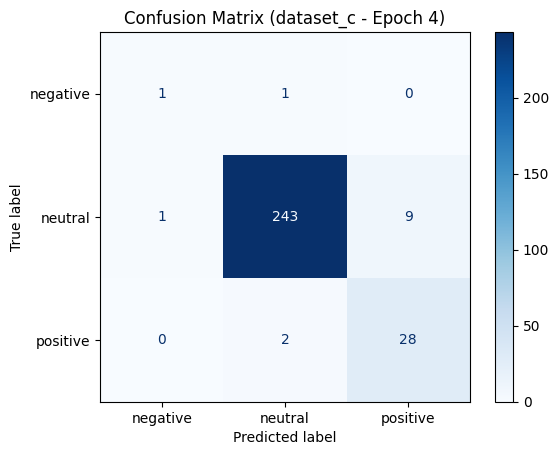

[dataset_c] Epoch 5 - Training:   0%|          | 0/72 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[dataset_c] Epoch 5 - Training: 100%|██████████| 72/72 [00:34<00:00,  2.12it/s]

[dataset_c] Epoch 5 - Train Loss: 0.0292
              precision    recall  f1-score   support

    negative     1.0000    0.9667    0.9831        30
     neutral     0.9946    0.9970    0.9958      2023
    positive     0.9735    0.9565    0.9649       230

    accuracy                         0.9926      2283
   macro avg     0.9893    0.9734    0.9813      2283
weighted avg     0.9925    0.9926    0.9925      2283




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_c] Epoch 5 - Validation Loss: 0.1794
              precision    recall  f1-score   support

    negative     0.5000    0.5000    0.5000         2
     neutral     0.9799    0.9644    0.9721       253
    positive     0.7647    0.8667    0.8125        30

    accuracy                         0.9509       285
   macro avg     0.7482    0.7770    0.7615       285
weighted avg     0.9539    0.9509    0.9520       285



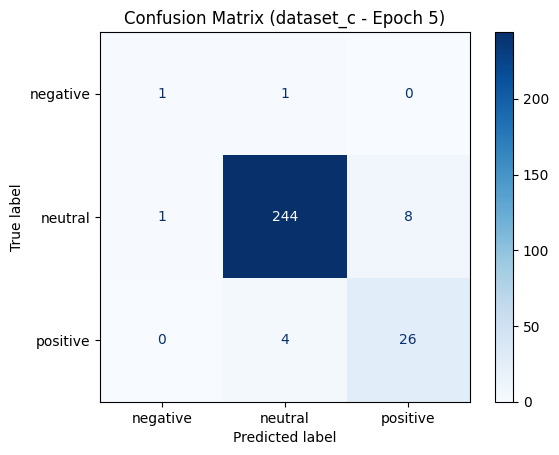

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[dataset_c] Test Prediction Labels: [1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
✅ Model dataset_c disimpan di: /content/drive/MyDrive/Colab Notebooks/Skripsi/Model/saved_model_dataset_c

In [ ]:
# Training dan Evaluasi
n_epochs = 5

for dataset_name, dataloaders in loaded_dataloaders.items():
    print(f"\n=== Mulai Training untuk {dataset_name} ===")

    train_loader = dataloaders['train']
    valid_loader = dataloaders['valid']
    test_loader = dataloaders['test']

    # Reset model dan optimizer
    model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    for epoch in range(n_epochs):
        # Training
        model.train()
        total_train_loss = 0
        list_train_hyp, list_train_label = [], []

        train_pbar = tqdm(train_loader, desc=f"[{dataset_name}] Epoch {epoch+1} - Training")
        for input_ids, attention_mask, labels in train_pbar:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs.logits, dim=1)
            list_train_hyp += preds.cpu().numpy().tolist()
            list_train_label += labels.cpu().numpy().tolist()

        print(f"[{dataset_name}] Epoch {epoch+1} - Train Loss: {total_train_loss/len(train_loader):.4f}")
        print(classification_report(list_train_label, list_train_hyp, target_names=['negative', 'neutral', 'positive'], digits=4))

        # Validation
        model.eval()
        list_val_hyp, list_val_label = [], []
        total_val_loss = 0

        with torch.no_grad():
            for input_ids, attention_mask, labels in valid_loader:
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()

                _, preds = torch.max(outputs.logits, dim=1)
                list_val_hyp += preds.cpu().numpy().tolist()
                list_val_label += labels.cpu().numpy().tolist()

        print(f"[{dataset_name}] Epoch {epoch+1} - Validation Loss: {total_val_loss/len(valid_loader):.4f}")
        print(classification_report(list_val_label, list_val_hyp, target_names=['negative', 'neutral', 'positive'], digits=4))

        # Confusion Matrix
        cm = confusion_matrix(list_val_label, list_val_hyp, labels=[0,1,2])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
        disp.plot(cmap='Blues', values_format='d')
        plt.title(f"Confusion Matrix ({dataset_name} - Epoch {epoch+1})")
        plt.show()

        # Test Set
    model.eval()
    list_test_preds = []

    with torch.no_grad():
        for input_ids, attention_mask, _ in test_loader:
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            list_test_preds += preds.cpu().numpy().tolist()

    print(f"[{dataset_name}] Test Prediction Labels:", list_test_preds)

    # ================== SIMPAN MODEL (hanya satu versi, hasil akhir) ==================
    model_save_path = f"/content/drive/MyDrive/Colab Notebooks/Skripsi/Model/saved_model_{dataset_name.lower()}.pt"
    torch.save(model.state_dict(), model_save_path)
    print(f"✅ Model {dataset_name} disimpan di: {model_save_path}")
